In [1]:
!pip install jieba

In [2]:
import pandas as pd
import pymysql
import jieba
import jieba.analyse
import time
import warnings 
warnings.filterwarnings("ignore")

In [4]:
# tStart = time.time() #計時開始

# https://sites.google.com/site/zsgititit/home/python-cheng-shi-she-ji/shi-yongpython-congmysql-zhua-qu-mei-ri-gu-jia-zi-liao-yu-shi-yongpandas-jin-xing-fen-xi
#從資料庫內匯入資料變成dataframe
MYSQL_HOST = 'localhost'
MYSQL_DB = 'mobile01(20190108)'
MYSQL_USER = 'root'
MYSQL_PASS = ''

brands=['sony']
def connect_mysql():  #連線資料庫
    global connect, cursor
    connect = pymysql.connect(host = MYSQL_HOST, db = MYSQL_DB, user = MYSQL_USER, password = MYSQL_PASS,
            charset = 'utf8', use_unicode = True)
    cursor = connect.cursor()

connect_mysql()   #呼叫連線資料庫函式

for brand in brands:
    mobile = pd.read_sql('SELECT * FROM sony', con = connect) #使用connect指定的Mysql獲取資料
#     mobile.head(10)
    
connect.close()  #記得關閉連線(因為要用迴圈取品牌,所以要放到迴圈外)

In [17]:
mobile.head(5)

,content
0,善變沒天良 wrote:剛剛跑了神腦門市和...(恕刪)，可以！原本中華4G，在中華直營門市...
1,Jacob-mms wrote:請下載其他 Launcher (啟動器??)https://...
2,從2016年初買了 Sony Xperia Z5 Performance當初買Z5P主要還是...
3,"感謝小惡魔舉辦這次的體驗活動, 讓我在Find7a之後能有機會再次體驗OPPO家的手機：R9..."
4,2-3項應該算同一問題，沒有壞掉，就不用修理。你就買大廠牌一點的4.不需要常充電，那就買大電...


In [ ]:
#確認低中高階的資料筆數
mobile['Name_exp_2'].value_counts()

In [4]:
#只篩選出有列舉出來的型號 排除other的文章不看
mobile_high_medium_low = mobile[mobile['Name_exp_2'] != 'OTHER']
mobile_high_medium_low.head(10)
# mobile_high_medium_low[mobile_high_medium_low['Name_exp_2'] == 'high']
# mobile_high_medium_low[mobile_high_medium_low['Name_exp_2'] == 'medium']
# mobile_high_medium_low[mobile_high_medium_low['Name_exp_2'] == 'low']

,content,Name_exp_2
4,crazysunday wrote:因為公司補助一個月1500...(恕刪)沒看過豬走路也吃...,medium
8,tree0525 wrote:我的沒JB，但也是更...(恕刪)兩支設備 IPHONE 6S...,medium
11,把手機連上iTuse 備份然後重新刷一次就可以了 以前IOS7也有發生過類似問題~再不行就直...,medium
13,ma2882 wrote:今天看到三星廣告，...(恕刪) ４９０元＂起＂那個ＬＥＤ燈的確４...,low
15,"ma2882 wrote:今天看到三星廣告，...(恕刪)""起""!!!只要LED燈賣490，...",low
33,ma2882 wrote:我知道各位的意思，...(恕刪)我也一時之間沒注意到這問題，我沒仔...,low
35,ma2882 wrote:我知道各位的意思，...(恕刪)沒有要買 或是沒買 就沒有申訴的立...,low
37,上週因為mate9供貨已經正常，在官網搶購了一台白色的6+128並加了保險。貨送到後，開機把...,medium
40,請問要如何裝上google service謝謝,medium
55,tacomouse wrote:請問這條歌是哪個團...(恕刪)WORLD ORDER 唱的...,medium


In [19]:
#使用jieba斷詞
jieba.set_dictionary('dict.txt')    #匯入繁體字典
jieba.load_userdict('userdict.txt')  #匯入自定義字典

Building prefix dict from C:\Users\Freya\dict.txt ...
Dumping model to file cache C:\Users\Freya\AppData\Local\Temp\jieba.uf7d78eb99fd438e6459a4415ad8f1e8a.cache
Loading model cost 1.460 seconds.
Prefix dict has been built succesfully.


In [20]:
# 匯入中文的停用字字典 變成 stopWords list

stopWords=[] #創一個空的停用詞字典

with open('Stop Words.txt', 'r', encoding='UTF-8') as file: 
    for data in file.readlines():
        data = data.strip()
        stopWords.append(data)

# #由於一些符號 直接在txt檔輸入 無法被辨識出來 所以直接append到stopWords上 
stopWords.append(')') 
stopWords.append('(') 
stopWords.append(' ') 
stopWords.append('\r\n')
stopWords.append('.')
stopWords.append('\r')
stopWords.append('\t')
stopWords.append('')
stopWords.append('●')
stopWords.append('or')
stopWords.append('of')
stopWords.append('. ')
stopWords.append('•')
stopWords.append('【')
stopWords.append('】')
stopWords.append('‧')
stopWords.append('／')
stopWords.append('…')
stopWords.append(' & ')
stopWords.append('★')
stopWords.append('.  ')
stopWords.append('  ')
stopWords.append('－')
stopWords.append('「')
stopWords.append('www')
stopWords.append('　')
stopWords.append('nan')
# stopWords

In [21]:
#建立文字雲所需list
def makewordlist(df):

    wordlist = pd.Series()
    wordlist = wordlist.append(df['content'])

    kw=[]
    
    #斷詞
    for t in wordlist:
        tt = str(t)
        ks = jieba.cut( tt.lower() )
        kw.extend( ks )

    #過濾停用字
    rkw = list(filter(lambda a: a not in stopWords and a != '\n', kw))

    return rkw

In [22]:
#計算詞頻
def wordfreq(data):
    
    ck = pd.Series() #變成 Series可以去算詞頻
    
    for i in data:
        ck = ck.append( pd.Series(i) )

    sc = ck.value_counts() #算詞頻 
    return sc

In [23]:
tStart = time.time() #計時開始


#建立詞表
rkw_data = makewordlist(mobile)
#計算詞頻
sc_data = wordfreq(rkw_data)

tEnd = time.time() #計時結束
print('======計時結束=======')
print("It cost %f sec" % (tEnd - tStart))

======計時結束=======
It cost 3317.986484 sec


In [24]:
sc_data

螢幕              1762
拍               1687
功能              1675
拍照              1464
模式              1448
pro             1352
相機              1345
htc             1280
照片              1265
android         1055
plus            1032
r9s              952
                 809
鏡頭               797
google           764
hdr              734
mate             728
app              706
4g               687
更新               679
吋                676
華為               672
影片               670
效果               659
電池               648
品牌               638
xperia           607
規格               605
ai               602
時間               598
                ... 
戶端                 1
a0972199950        1
死水                 1
sulusulu0801       1
高雄氣                1
錄後設                1
行車紀                1
航六小時               1
稅費                 1
期許                 1
程序管理               1
強型                 1
連素顏                1
擅自                 1
強大硬體               1
搬張                 1
登基           

### 由詞頻觀察哪些字不重要放入stopWords中

In [25]:
tStart = time.time() #計時開始

ck = pd.Series() #變成 Series 可以去算詞頻
for i in rkw_data:
    ck = ck.append(pd.Series(i))

sc = ck.value_counts() #算詞頻

tEnd = time.time() #計時結束
print('======計時結束=======')
print("It cost %f sec" % (tEnd - tStart))
print(len(sc))

======計時結束=======
It cost 3221.738360 sec
57755


In [26]:
sc.index[:100]

Index(['螢幕', '拍', '功能', '拍照', '模式', 'pro', '相機', 'htc', '照片', 'android',
       'plus', 'r9s', ' ', '鏡頭', 'google', 'hdr', 'mate', 'app', '4g', '更新',
       '吋', '華為', '影片', '效果', '電池', '品牌', 'xperia', '規格', 'ai', '時間', '直接',
       'p20', '設定', '一些', '測試', '需要', '指紋', '版本', '高', '不錯', '部分', '速度', '前',
       'asus', '分享', '版', '小', '充電', '辨識', '元', '開箱', 'u11', '開啟', '光圈', '採用',
       '智慧', 'r15', '喜歡', '自動', '耳機', '萬畫素', '卡', '畫質', 'lg', '錢', '賣', '搭配',
       '體驗', '網路', 'nfc', '▼', '感光', '正常', '推出', 'ios', '元件', '紅米', '日本', '找',
       'pixel', '亮度', '美顏', '處理器', 'xz', '朋友', '一點', '焦', '價格', '製', '自拍',
       '上市', '地方', '攝', '出現', '算是', '方式', '防水', 'nokia', '使用者', '狀況'],
      dtype='object')

In [27]:
sc.index[100:200]

Index(['畫面', '3d', 'r17', '整體', '旗艦', '3g', 'sim', '則是', '解鎖', '表現', 'huawei',
       '檢視', 'xzp', '細節', '機身', '原廠', '顯示', '介面', '差', 'oled', '長', '參考', '簡單',
       '高通', 'c', '相當', 'mm', 'zenfone', '原本', '夜景', '方案', '2017', '方便', 'mix',
       '掉', '先', '錄影', 'note', '秒', '20', '認為', '效能', '拍攝', '喇叭', '遊戲', 'r11s',
       '便宜', '低', '硬體', '明顯', '台', '調整', '推薦', '☢', '最大', '11', '顏色', 'line',
       'ram', '4k', '左右', '行動', '內建', 's9', '選', 'ultra', '容易', '一次', '最高',
       '開', '玻璃', 'galaxy', '市場', '容量', '無線', '升級', '係', '同樣', '實際', '解析度',
       '想要', '以下', '謝謝', '外型', '特別', 'z3', '中國', '一台', 'ca', '原因', '機種',
       'wifi', '背面', '不好', 'exif', '外', '雙鏡頭', '下載', '第一', '一年'],
      dtype='object')

### 建立產生文字雲的函數

In [28]:
! pip install wordcloud

In [29]:
! pip install palettable

You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [33]:
! pip install collections

  Could not find a version that satisfies the requirement collections (from versions: )
No matching distribution found for collections
You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [29]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random
from palettable.colorbrewer.qualitative import Dark2_8 #字詞的顏色色盤 可以自己上網找喜歡的做更改
from collections import Counter
import numpy as np
from PIL import Image

In [30]:
def toolwordcloud(data,mask,filename):
    
    #定義字詞顏色色盤
    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return tuple(Dark2_8.colors[random.randint(0,7)]) #有八個顏色去做random
    
    word_could_dict = Counter(data) #data要經過計數
    bg_pic = np.array(Image.open(mask)) #要用這張圖當輪廓
    
    #建立文字雲
    wordcloud = WordCloud(width = 1000, height = 500,font_path = "msjhbd.ttc",max_words=400,mask=bg_pic,background_color="white").generate_from_frequencies(word_could_dict)
    #換字的顏色
    wordcloud.recolor(color_func = color_func, random_state=2) 
    #存圖
    wordcloud.to_file(filename)
    #顯示圖
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    plt.close()

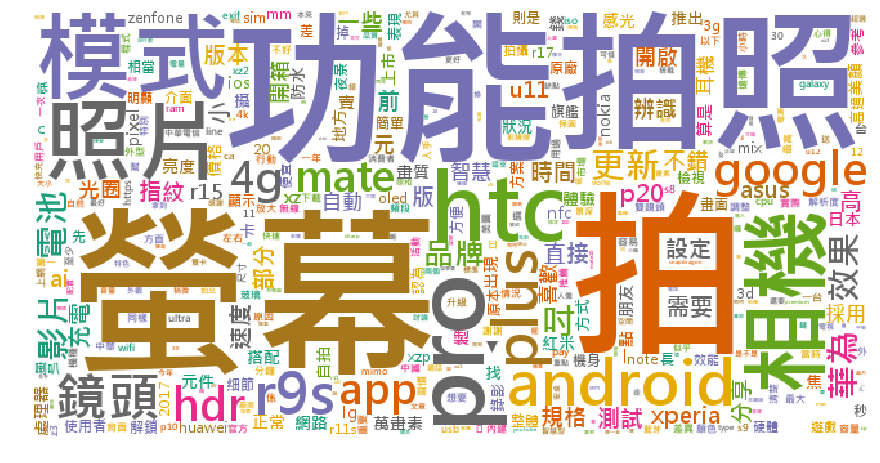

In [31]:
toolwordcloud(rkw_data,r"cloud.png",'data_wordcloud.png')